<a href="https://colab.research.google.com/github/cisongeffy/CustomerChurn/blob/main/PredictionModeling_CustomerChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. data exploration:
  - info overview #drop the last two columns #drop clinetnum
  - check missing value #（isna.())
  - one hot encoding
  - data correlation # 0 and 1
    - drop low-correlated columns **try to drop marrige**
  - data distribution # found out "unknown"
    - target value
    - unique values in non-numurical features
    - tho unbalanced, no smote because we have enough obeservations

2. Missing Value Imputation: **for income_level and education_level**
  - imputation for each missing colulmn to find the best imputation
  - knn imputer(grid search)
  - most frequent

3. fit on models:
**k-fold**

**grid-search**
  - decision tree (depth, max..
  - KNN (n_neighbor

4. metrics to measure performance:
  - F1 scores
  - PR curve

In [ ]:
import pandas as pd
import numpy as np
import io
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, make_scorer

In [ ]:
# Load Data
from google.colab import files
uploaded = files.upload()

Saving BankChurners.csv to BankChurners (5).csv


# **Data Exploration**

In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['BankChurners.csv']))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

In [ ]:
# Drop unnecessary columns "Marital_Status", "CLIENTNUM " "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count" "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count"
df1 = df.drop(df.columns[[6, 0, -1,-2]], axis=1)

In [ ]:
# Check for missing values
print(df1.isnull().sum())

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64


In [ ]:
#Check the number of unique value in non-numerical feature
for i in range(df1.shape[1]):
    if df1.iloc[:, i].dtype == 'object':
        print(i, df1.iloc[:, i].name, df1.iloc[:, i].unique())

0 Attrition_Flag ['Existing Customer' 'Attrited Customer']
2 Gender ['M' 'F']
4 Education_Level ['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate']
5 Income_Category ['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']
6 Card_Category ['Blue' 'Gold' 'Silver' 'Platinum']


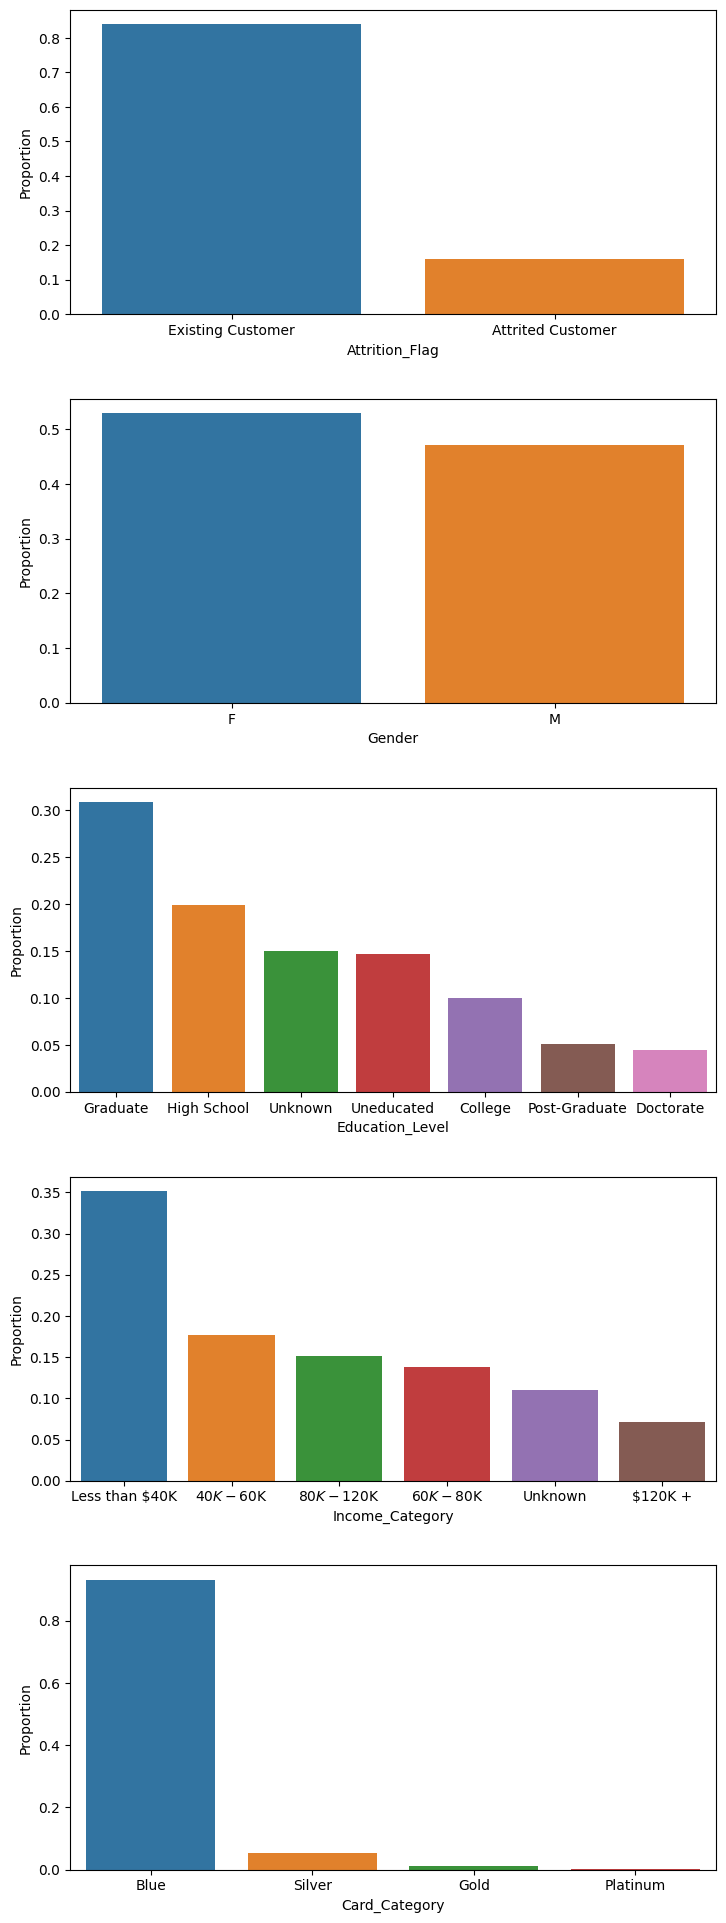

In [ ]:
# Plot distribution for categorical variables
categorical_vars = ['Attrition_Flag', 'Gender', 'Education_Level', 'Income_Category', 'Card_Category']
fig, axes = plt.subplots(len(categorical_vars), 1, figsize=(8, len(categorical_vars)*4))
fig.tight_layout(pad=4.0)
for i, var in enumerate(categorical_vars):
    proportions = df[var].value_counts(normalize=True)
    sns.barplot(x=proportions.index, y=proportions.values, ax=axes[i])
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Proportion')
plt.show()

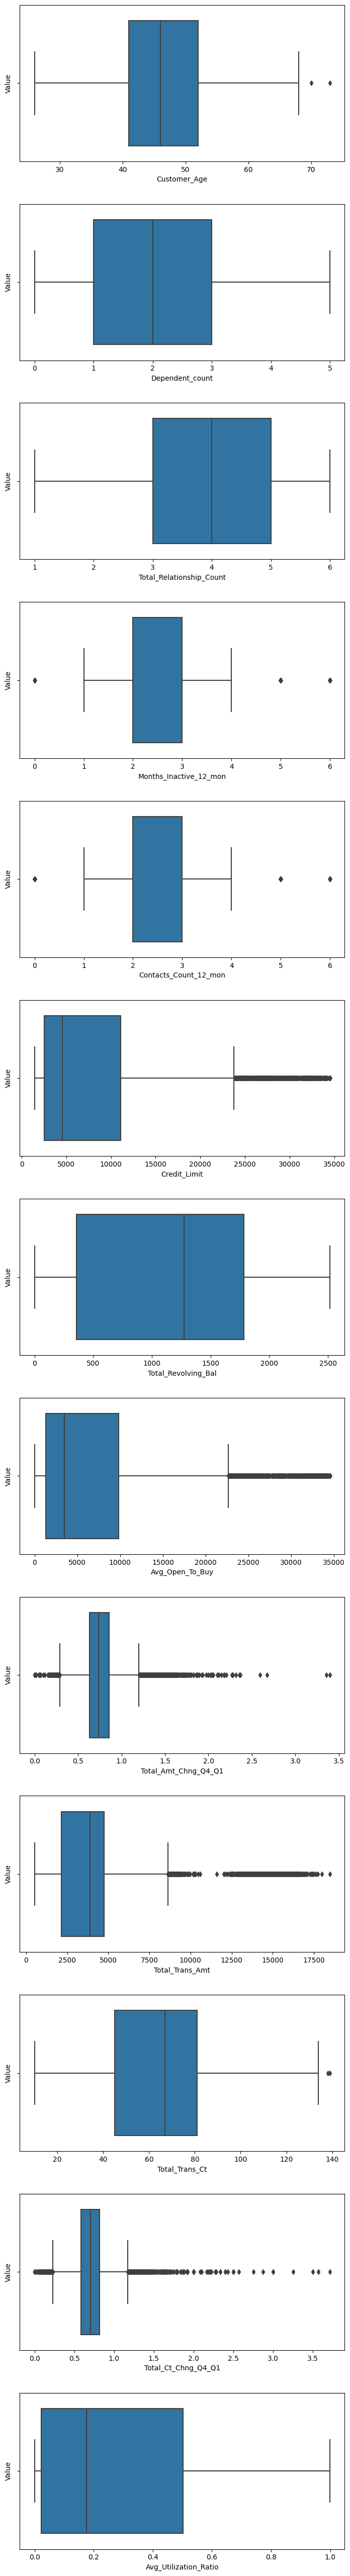

In [ ]:
# Plot distribution for numerical variables
numerical_vars = df1.columns[[1, 3, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]]
fig, axes = plt.subplots(len(numerical_vars), 1, figsize=(8, len(numerical_vars)*4))
fig.tight_layout(pad=4.0)
for i, var in enumerate(numerical_vars):
    sns.boxplot(x=var, data=df, ax=axes[i])
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Value')
plt.show()

# **Missing Value Imputation**

In [ ]:
# "Unknown" value imputation
df1.replace('Unknown', np.nan, inplace=True)
print(df1.isnull().sum())

Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count                0
Education_Level             1519
Income_Category             1112
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Avg_Open_To_Buy                0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
dtype: int64


In [ ]:
# Encode categorical variables
label_encoders = {}
for col in categorical_vars:
    label_encoders[col] = LabelEncoder()
    df1[col] = label_encoders[col].fit_transform(df1[col])


In [ ]:
df1['Education_Level'].unique()

array([3, 2, 5, 6, 0, 4, 1])

In [ ]:
# Specify your columns to be imputed here
columns_to_impute = ['Education_Level', 'Income_Category']

In [ ]:
# Make a copy to imputate data
df_i = df1.copy()

In [ ]:
# KNNImputer - find the best n_neighbors
grid_params = {'n_neighbors': [3,5,7,9,11]}

knn_imputer = KNNImputer()
cross_val = KFold(n_splits=5)

best_params = None
best_score = np.inf
for param in grid_params['n_neighbors']:
    knn_imputer.set_params(n_neighbors=param)
    scores = []
    for train_index, val_index in cross_val.split(df_i[columns_to_impute]):
        X_train, X_val = df_i.iloc[train_index][columns_to_impute], df_i.iloc[val_index][columns_to_impute]
        imputed_data = knn_imputer.fit_transform(X_train)
        scores.append(np.sum(np.isnan(imputed_data)))
    mean_score = np.mean(scores)
    if mean_score < best_score:
        best_score = mean_score
        best_params = {'n_neighbors': param}

print(f"Best KNNImputer params: {best_params}")

Best KNNImputer params: {'n_neighbors': 3}


In [ ]:
df_in = df1.copy()

In [ ]:
# Impute with n_neighbors = 3
df_impute = df_in[columns_to_impute].copy()
knn_imputer = KNNImputer(n_neighbors=3)
df_impute[columns_to_impute] = knn_imputer.fit_transform(df_impute)
df_in[columns_to_impute] = df_impute[columns_to_impute]

In [ ]:
df_in['Education_Level'].unique()

array([3., 2., 5., 6., 0., 4., 1.])

In [ ]:
original_education_levels = label_encoders['Education_Level'].inverse_transform(df_in['Education_Level'].astype(int))
print(original_education_levels)

['High School' 'Graduate' 'Graduate' ... 'High School' 'Graduate'
 'Graduate']


In [ ]:
df_in['Income_Category'].unique()

array([2., 4., 3., 1., 0., 5.])

In [ ]:
df_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  int64  
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  int64  
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  float64
 5   Income_Category           10127 non-null  float64
 6   Card_Category             10127 non-null  int64  
 7   Months_on_book            10127 non-null  int64  
 8   Total_Relationship_Count  10127 non-null  int64  
 9   Months_Inactive_12_mon    10127 non-null  int64  
 10  Contacts_Count_12_mon     10127 non-null  int64  
 11  Credit_Limit              10127 non-null  float64
 12  Total_Revolving_Bal       10127 non-null  int64  
 13  Avg_Open_To_Buy           10127 non-null  float64
 14  Total_

In [ ]:
df_in.isna().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [ ]:
# Most Frequent Imputer
df_mf = df1.copy()
freq_imputer = SimpleImputer(strategy='most_frequent')
df_mf[columns_to_impute] = freq_imputer.fit_transform(df_mf[columns_to_impute])

In [ ]:
df_mf.isna().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

# **Fit on Models**

In [ ]:
df_knn3 = df_in


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_recall_curve, auc
import time

    rank_test_score  mean_test_score param_max_depth param_min_samples_leaf
0                21         0.950953               3                      1
1                21         0.950953               3                      2
2                21         0.950953               3                      3
3                21         0.950953               3                      4
4                21         0.950953               3                      5
5                16         0.959567               5                      1
6                20         0.959350               5                      2
7                17         0.959509               5                      3
8                18         0.959509               5                      4
9                19         0.959438               5                      5
10                1         0.965656               7                      1
11                2         0.965600               7                      2
12          

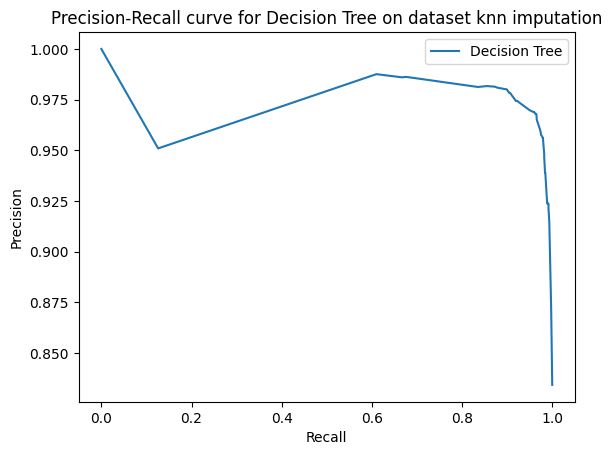

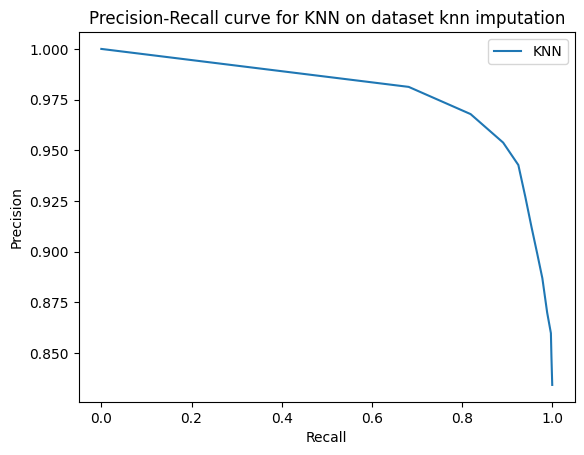

    rank_test_score  mean_test_score param_max_depth param_min_samples_leaf
0                21         0.950953               3                      1
1                21         0.950953               3                      2
2                21         0.950953               3                      3
3                21         0.950953               3                      4
4                21         0.950953               3                      5
5                16         0.959567               5                      1
6                20         0.959350               5                      2
7                17         0.959509               5                      3
8                18         0.959509               5                      4
9                19         0.959438               5                      5
10                1         0.965656               7                      1
11                2         0.965600               7                      2
12          

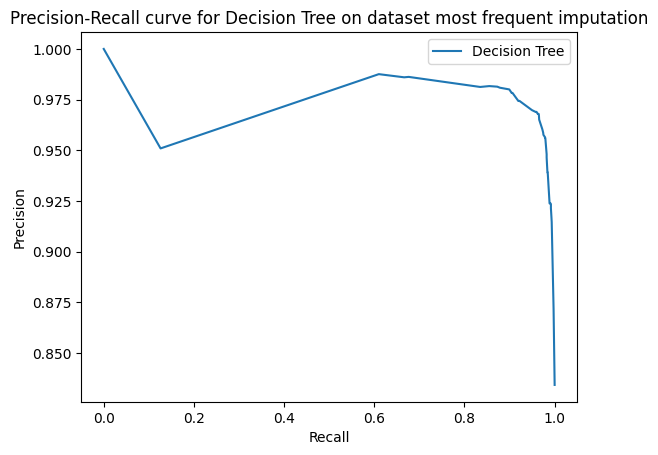

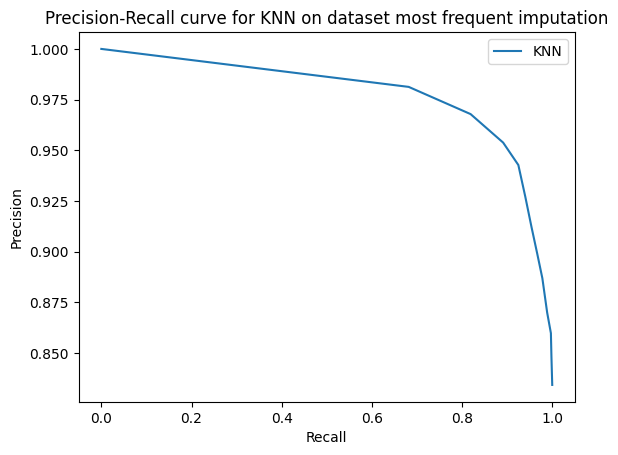

In [ ]:

# Prepare your datasets
datasets = {'knn imputation': df_knn3, 'most frequent imputation': df_mf}

# Prepare grid parameters for Decision Tree and KNN
grid_params_dt = {'max_depth': [3,5,7,9,11], 'min_samples_leaf': [1,2,3,4,5]}
grid_params_knn = {'n_neighbors': [3,5,7,9,11]}

# Initialize dictionaries to store models and scores
dt_models = {}
knn_models = {}
dt_scores = {}
knn_scores = {}

# Iterate over each dataset
for dataset_name, data in datasets.items():
    # Train test split
    X = data.drop('Attrition_Flag', axis=1)
    y = LabelEncoder().fit_transform(data['Attrition_Flag'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

    # Decision Tree
    dt = DecisionTreeClassifier(random_state=3)
    dt_gscv = GridSearchCV(dt, grid_params_dt, cv=5, scoring='f1')

    # Timing the training process for Decision Tree
    start_time = time.time()
    dt_gscv.fit(X_train, y_train)
    end_time = time.time()

    # Create and print the results DataFrame for Decision Tree
    dt_results = pd.DataFrame(dt_gscv.cv_results_)
    print(dt_results[['rank_test_score','mean_test_score','param_max_depth','param_min_samples_leaf']])

    print(f"Training Time for Decision Tree on dataset {dataset_name}: {end_time - start_time} seconds")
    print(f"Best Decision Tree params for dataset {dataset_name}: {dt_gscv.best_params_}")
    print(f"Best cross-validation F1 score for Decision Tree on dataset {dataset_name}: {dt_gscv.best_score_}")

    # Store the best Decision Tree model and its test F1 score
    dt_models[f'dt_{dataset_name}'] = dt_gscv.best_estimator_
    dt_scores[f'dt_{dataset_name}'] = f1_score(y_test, dt_gscv.predict(X_test))

    # KNN
    knn = KNeighborsClassifier()
    knn_gscv = GridSearchCV(knn, grid_params_knn, cv=5, scoring='f1')

    # Timing the training process for KNN
    start_time = time.time()
    knn_gscv.fit(X_train, y_train)
    end_time = time.time()

    # Create and print the results DataFrame for KNN
    knn_results = pd.DataFrame(knn_gscv.cv_results_)
    print(knn_results[['rank_test_score','mean_test_score','param_n_neighbors']])

    print(f"Training Time for KNN on dataset {dataset_name}: {end_time - start_time} seconds")
    print(f"Best KNN params for dataset {dataset_name}: {knn_gscv.best_params_}")
    print(f"Best cross-validation F1 score for KNN on dataset {dataset_name}: {knn_gscv.best_score_}")

    # Store the best KNN model and its test F1 score
    knn_models[f'knn_{dataset_name}'] = knn_gscv.best_estimator_
    knn_scores[f'knn_{dataset_name}'] = f1_score(y_test, knn_gscv.predict(X_test))

    # Plot Precision-Recall curves for Decision Tree and KNN
    precision, recall, _ = precision_recall_curve(y_test, dt_gscv.predict_proba(X_test)[:, 1])
    plt.plot(recall, precision, label='Decision Tree')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve for Decision Tree on dataset {dataset_name}')
    plt.legend()
    plt.show()

    precision, recall, _ = precision_recall_curve(y_test, knn_gscv.predict_proba(X_test)[:, 1])
    plt.plot(recall, precision, label='KNN')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve for KNN on dataset {dataset_name}')
    plt.legend()
    plt.show()

In [ ]:
# Print out the best F1 scores for each model
print("Best F1 scores for Decision Tree models:")
for model, score in dt_scores.items():
    print(f"{model}: {score}")

print("\nBest F1 scores for KNN models:")
for model, score in knn_scores.items():
    print(f"{model}: {score}")


Best F1 scores for Decision Tree models:
dt_knn imputation: 0.9665492957746479
dt_most frequent imputation: 0.9665492957746479

Best F1 scores for KNN models:
knn_knn imputation: 0.932600520682673
knn_most frequent imputation: 0.932600520682673


In [ ]:
education_level_proportions_in = df_knn3['Education_Level'].value_counts(normalize=True)
print(education_level_proportions_in)
education_level_proportions_mf = df_mf['Education_Level'].value_counts(normalize=True)
print(education_level_proportions_mf)

2.0    0.308877
3.0    0.198776
6.0    0.149995
5.0    0.146835
0.0    0.100030
4.0    0.050953
1.0    0.044534
Name: Education_Level, dtype: float64
2    0.308877
3    0.198776
6    0.149995
5    0.146835
0    0.100030
4    0.050953
1    0.044534
Name: Education_Level, dtype: float64


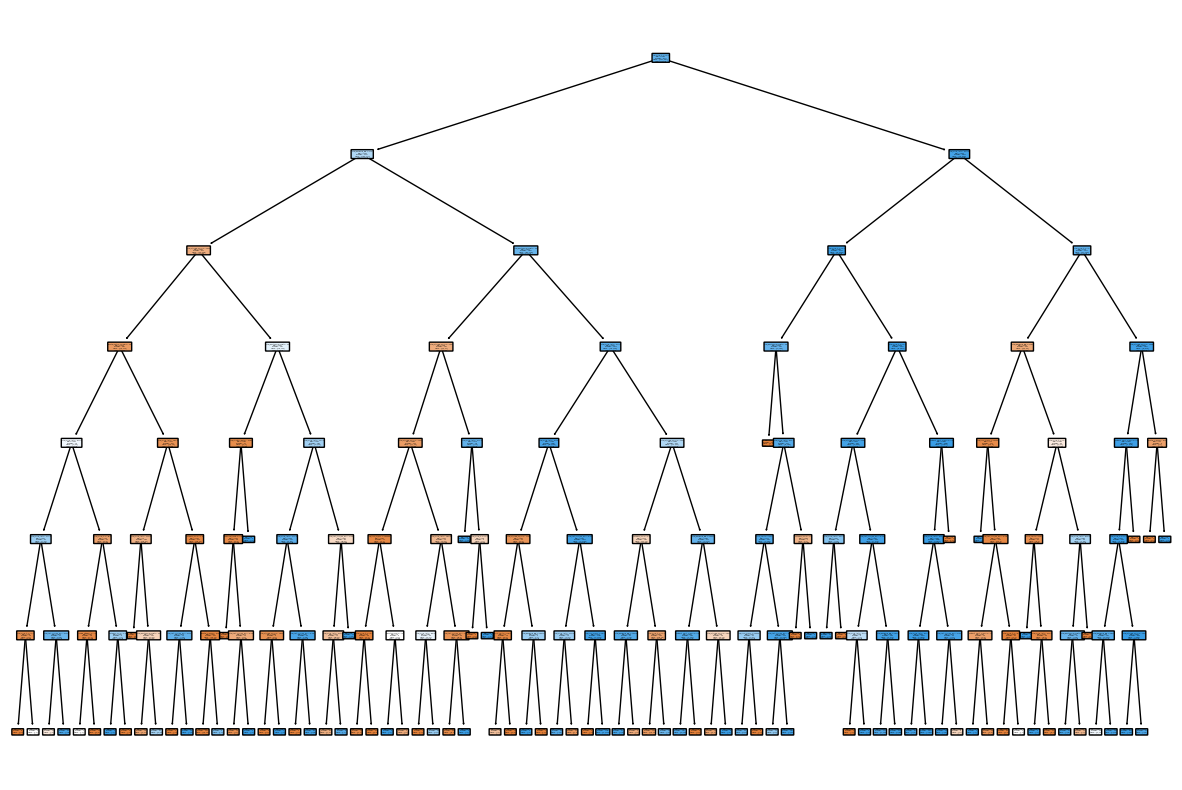

In [ ]:
# visualize decision tree
from sklearn.tree import plot_tree

# Get the best model from GridSearchCV
best_dt_model = dt_gscv.best_estimator_

# Plot the decision tree of the best model
plt.figure(figsize=(15,10))
plot_tree(best_dt_model, filled=True, rounded=True, feature_names=X.columns, class_names=['Attrited', 'Existing'])
plt.show()


Feature: Customer_Age, Score: 0.03095
Feature: Gender, Score: 0.00000
Feature: Dependent_count, Score: 0.00064
Feature: Education_Level, Score: 0.00086
Feature: Income_Category, Score: 0.00051
Feature: Card_Category, Score: 0.00000
Feature: Months_on_book, Score: 0.00332
Feature: Total_Relationship_Count, Score: 0.09899
Feature: Months_Inactive_12_mon, Score: 0.01208
Feature: Contacts_Count_12_mon, Score: 0.00880
Feature: Credit_Limit, Score: 0.00341
Feature: Total_Revolving_Bal, Score: 0.23104
Feature: Avg_Open_To_Buy, Score: 0.01057
Feature: Total_Amt_Chng_Q4_Q1, Score: 0.02584
Feature: Total_Trans_Amt, Score: 0.14739
Feature: Total_Trans_Ct, Score: 0.35471
Feature: Total_Ct_Chng_Q4_Q1, Score: 0.06991
Feature: Avg_Utilization_Ratio, Score: 0.00098


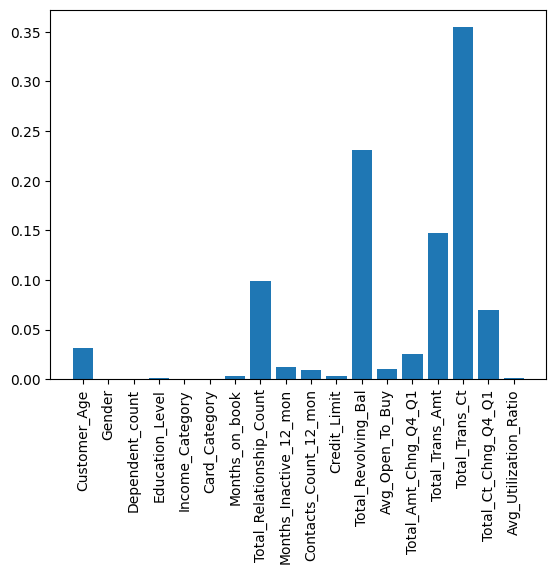

In [ ]:
# Feature importance
# Best Decision Tree model
best_dt_model = dt_models['dt_knn imputation']

# Get feature importance
importance = best_dt_model.feature_importances_

# Summarize feature importance
for i, j in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (X.columns[i], j))

# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(ticks=range(len(X.columns)), labels=X.columns, rotation='vertical')
plt.show()
